# Neural Particles 2D

## 2D Dataset
Pipeline:
* Generation of high-res data (reference) using some random cubes of water
* Extracting relevant data (particle data and grid data) like e.g. sdf, velocity, pressure, density...
* Down-sampling of particles (by a given factor) and generation of the low-res data (source)
* Extract corresponding and relevant patches on the surface from the data-set pairs (considering the low-res data)
* Use patche-pairs to train the NN

### Setup

Simple structs containing parameters for different data-set and neural network versions.

Data-set Parameters:
* **prefix**: prefix of filename
* **nn_version**: used neural network version
* **patch_size**: size of generated surface patches (of the low-res data)
* **stride**: stride used for the generation of the patches
* **surf**: surface tolerance, specifies which sdf-values are considered as surface (for patches)
* **fps**: frames per second, the velocity of the simulation
* **frame_count**: count of generated frames
* **sub_res**: count of particles per cell (per dimension)
* **res**: resolution of high-res grid
* **var1**: factor of drop falling in basin data-sets (var0 is 1 - var1 - var2)
* **var2**: factor of two drop shooting against other
* **factor**: goal up-scale factor of particles
* **upres**: specify if the low-res grids will be up-scaled to res (=> input and output same scale)
* **l_fac**: multiplicative factor of low-res sdf-patches
* **h_fac**: multiplicative factor of high-res sdf-patches
* **use_tanh**: apply tanh on sdf-patches, after multiplication with factor
* **seed**: seed for random data-set generation
* **min_scale**: minimum scale of boxes for data-set generation
* **max_scale**: maximum scale of boxes for data-set generation
* **min_pos**: minimum x-position of boxes
* **max_pos**: maximum x-position of boxes
* **max_h**: maximum start-height of boxes
* **max_cnt**: maximum count of boxes
* **circ_vel**: velocity used for colliding drops

Neural Network Parameters:
* **train_data_count**: count of training data-sets
* **val_split**: factor of how much of training data is used for validation
* **test_data_count**: count of test data-sets
* **t_start**: timestep start-point of data
* **t_end**: timestep end-point of data
* **features**: list of strings which specifiy which features to use:
    * 'sdf': levelset data
    * 'vel': velocity data
    * 'dens': density data
    * 'pres': pressure data
* **batch_size**: batch size used for training and validation
* **learning_rate**: learing rate used for training
* **epochs**: training epochs

In [1]:
class DatasetParam:
    def __init__(self, prefix="sph_2D", nn_version=0, patch_size=9, stride=3, surf=0.2, 
                fps=30, frame_count=50, sub_res=2, res=150, factor=10, upres=1, var1=0, var2=0,
                l_fac=1.0,h_fac=1.0,use_tanh=0,
                seed=124820112, min_scale=0.05, max_scale=0.3,
                min_pos=0.2,max_pos=0.8,max_h=0.1,max_cnt=5, circ_vel=100.):
    
        self.prefix = prefix
        self.nn_version = nn_version
        self.patch_size = patch_size
        self.stride = stride
        self.surf = surf
        
        self.l_fac = l_fac
        self.h_fac = h_fac
        self.use_tanh = use_tanh

        self.fps = fps
        self.frame_count = frame_count
        self.sub_res = sub_res
        self.res = res
        self.factor = factor
        self.upres = upres
        
        self.var1 = var1
        self.var2 = var2

        self.seed = seed
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.min_pos = min_pos
        self.max_pos = max_pos
        self.max_h = max_h
        self.max_cnt = max_cnt    
        self.circ_vel = circ_vel

class NNParam:
    def __init__(self, train_data_count=5, val_split=0.2, test_data_count=1,
                 t_start = 20, t_end = 21, features=['sdf'], 
                 batch_size=32,learning_rate=0.002,epochs=1000, use_spc=False):
        self.train_data_count = train_data_count
        self.val_split = val_split
        self.test_data_count = test_data_count
        self.t_start = t_start
        self.t_end = t_end
        self.features = features
        self.batch_size = batch_size
        self.learning_rate=learning_rate
        self.epochs = epochs
        self.use_spc = use_spc


Data Version:
* **V0**: default values, input and output patches same size
* **V1**: smaller patches, input and output patches different size, uses simple post-processing of patches
* **V2**: different seed, uses different data-set types

NN Version:
* **V0**: CNN with only sdf data
* **V1**: also velocity as input
* **V2**: 'Subpixel Convolution' instead of 'Transposed Convolution'

In [13]:
data_version_param = [
    DatasetParam(),
    DatasetParam(upres=0,
                 factor=9,
                 stride=2,
                 surf=0.5,
                 patch_size=5,
                 nn_version=1,
                 l_fac=3.0,
                 use_tanh=1),
    DatasetParam(upres=0,
                 factor=9,
                 stride=2,
                 surf=0.5,
                 patch_size=5,
                 nn_version=2,
                 h_fac=4.,
                 l_fac=12.,
                 seed=123412144,
                 use_tanh=1,
                 var1=3./9,
                 var2=3./9)
]

nn_version_param = [
    NNParam(),
    NNParam(train_data_count=9, 
            test_data_count=1, 
            t_start=5,
            t_end=15,
            epochs=200,
            features=['sdf','vel']),
    NNParam(train_data_count=9, 
            test_data_count=1, 
            t_start=5,
            t_end=15,
            epochs=200,
            features=['sdf','vel'],
            use_spc=True)
]

In [14]:
import os
from subprocess import Popen, PIPE
import sys

sys.path.append("2D_SPH/scenes/tools")

import datetime

manta_loc = "2D_SPH/"

data_version = 2
data_param = data_version_param[data_version]

nn_param = nn_version_param[data_param.nn_version]

data_loc = "2D_data/"
src = "lowres"
ref = "highres"

# count of training/validation setups
data_count = nn_param.train_data_count + nn_param.test_data_count

verbose = False

def createFolder(p):
    if not os.path.exists(p):
        os.makedirs(p)
    
def create_curr_date_folder(path):
    now = datetime.datetime.now()
    path += "%04d%02d%02d"%(now.year,now.month,now.day)
    createFolder(path)
    return path + "/"

createFolder(data_loc)
createFolder(data_loc+src)
createFolder(data_loc+ref)
createFolder(data_loc+"patches")
createFolder(data_loc+"patches/"+src)
createFolder(data_loc+"patches/"+ref)
createFolder(data_loc+"result")
createFolder(data_loc+"screenshots")

src_prefix = "%s%s/%s_v%02d" % (data_loc, src, data_param.prefix, data_version)
ref_prefix = "%s%s/ref_%s_v%02d" % (data_loc, ref, data_param.prefix, data_version)

def remove_data(path_prefix):
    command = ["rm", path_prefix+"*"]
    print(" ".join(command) + "\n")
    proc = Popen(command, stdin=None, stdout=PIPE, stderr=PIPE)
    if verbose:
        for line in proc.stdout:
            print(line.decode('utf-8'))
    for line in proc.stderr:
        print(line.decode('utf-8'))

def run_manta(scene, param={},run=True):
    command = [manta_loc+"build/manta", manta_loc+scene]

    for k, v in param.items():
        command += [k, str(v)]
        
    print(" ".join(command) + "\n")
    
    if not run: return

    proc = Popen(command, stdin=None, stdout=PIPE, stderr=PIPE)

    if verbose:
        for line in proc.stdout:
            print(line.decode('utf-8'))
    for line in proc.stderr:
        print(line.decode('utf-8'))

Compute 2D down-scale factor:
$$lowres=\frac{res}{\sqrt(factor)}$$

In [15]:
import math

#remove_data(src_prefix)

low_res = data_param.res
high_patch_size = data_param.patch_size
factor_2D = 1.
if not data_param.upres:
    factor_2D = math.sqrt(data_param.factor)
    low_res = int(low_res/factor_2D)
    high_patch_size = int(high_patch_size*factor_2D)
    
print("2D factor: %f" % factor_2D)
print("low resolution: %d" % low_res)
print("big patch size. %d" % high_patch_size)

2D factor: 3.000000
low resolution: 50
big patch size. 15


### Generate High-res Data

In [16]:
import random

#remove_data(ref_prefix)

run = False
if not run: print("PRINTS ONLY CALLS! RUN NOT ACTIVATED\n")
    
param = {}

#disable gui
param['gui'] = 0

# resolution of domain
param['res'] = data_param.res
param['sres'] = data_param.sub_res

# output file format
param['out'] = ref_prefix

# write only every 30th frame -> 30 frames are one timestep
param['fps'] = data_param.fps

# simulation time (how many frames)
param['t_end'] = float(data_param.frame_count) / data_param.fps

# run random training setups
random.seed(data_param.seed)

def call_dataset_gen(var0,var1,var2,off):
    if run: print("var0: %d, var1: %d, var2: %d" % (var0, var1, var2))

    param['circ'] = 0
    for i in range(var0):
        param['out'] = (ref_prefix + "_d%03d")%off + "_%03d"

        # generate different cubes with dataformat "pos_x,pos_y,scale_x,scale_y"
        param['c_cnt'] = random.randint(1,data_param.max_cnt)
        cubes = {}
        for c in range(param['c_cnt']):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)
            scy = random.uniform(data_param.min_scale, data_param.max_scale)
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(0, data_param.max_h) + scy/2
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_manta("scenes/2D_sph.py", dict(param, **cubes), run)
        off+=1

    for i in range(var1):
        param['out'] = (ref_prefix + "_d%03d")%off + "_%03d"

        # generate different cubes with dataformat "pos_x,pos_y,scale_x,scale_y"
        param['c_cnt'] = random.randint(2,data_param.max_cnt)
        cubes = {}

        scy = data_param.max_h
        cubes['c0'] = "%f,%f,%f,%f"%(0, scy/2, 1, scy)
        for c in range(1,param['c_cnt']):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            scy = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(data_param.min_pos+scy/2, data_param.max_pos*0.5-scy/2)
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_manta("scenes/2D_sph.py", dict(param, **cubes), run)
        off+=1

    param['circ'] = data_param.circ_vel
    for i in range(var2):
        param['out'] = (ref_prefix + "_d%03d")%off + "_%03d"

        # generate different cubes with dataformat "pos_x,pos_y,scale_x,scale_y"
        param['c_cnt'] = random.randint(2,data_param.max_cnt)
        cubes = {}
        for c in range(param['c_cnt']):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            scy = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(data_param.min_pos+scy/2, data_param.max_pos-scy/2)
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_manta("scenes/2D_sph.py", dict(param, **cubes), run)
        off+=1
    
var1 = int(nn_param.train_data_count * data_param.var1)
var2 = int(nn_param.train_data_count * data_param.var2)
var0 = nn_param.train_data_count - var1 - var2

call_dataset_gen(var0,var1,var2,0)

var1 = int(nn_param.test_data_count * data_param.var1)
var2 = int(nn_param.test_data_count * data_param.var2)
var0 = nn_param.test_data_count - var1 - var2

call_dataset_gen(var0,var1,var2,nn_param.train_data_count)

PRINTS ONLY CALLS! RUN NOT ACTIVATED

2D_SPH/build/manta 2D_SPH/scenes/2D_sph.py out 2D_data/highres/ref_sph_2D_v02_d000_%03d sres 2 fps 30 gui 0 circ 0 res 150 t_end 1.6666666666666667 c_cnt 1 c0 0.494799,0.117561,0.235628,0.121357

2D_SPH/build/manta 2D_SPH/scenes/2D_sph.py c1 0.408424,0.188316,0.289150,0.235498 out 2D_data/highres/ref_sph_2D_v02_d001_%03d c2 0.698192,0.163711,0.081849,0.172705 c3 0.387485,0.126930,0.208639,0.167533 sres 2 fps 30 gui 0 circ 0 res 150 t_end 1.6666666666666667 c4 0.499663,0.072849,0.262631,0.087050 c_cnt 5 c0 0.646937,0.079092,0.167751,0.106881

2D_SPH/build/manta 2D_SPH/scenes/2D_sph.py c1 0.313436,0.106486,0.201034,0.203649 out 2D_data/highres/ref_sph_2D_v02_d002_%03d c2 0.540229,0.145842,0.143475,0.201570 c3 0.402537,0.077487,0.243389,0.112155 sres 2 fps 30 gui 0 circ 0 res 150 t_end 1.6666666666666667 c4 0.613239,0.133980,0.259161,0.238037 c_cnt 5 c0 0.549986,0.153319,0.245289,0.122646

2D_SPH/build/manta 2D_SPH/scenes/2D_sph.py c1 0.675735,0.26278

### Generate Low-res Data

In [17]:
param = {}

param['res'] = data_param.res
param['sres'] = data_param.sub_res
param['upres'] = data_param.upres
 
param['factor'] = data_param.factor
param['gui'] = 0
param['t'] = data_param.frame_count

for i in range(data_count):
    param['in'] = (ref_prefix + "_d%03d")%i + "_%03d"
    param['out'] = (src_prefix + "_d%03d")%i + "_%03d"
    run_manta("scenes/down_scale.py", param)

2D_SPH/build/manta 2D_SPH/scenes/down_scale.py in 2D_data/highres/ref_sph_2D_v02_d000_%03d t 50 factor 9 upres 0 res 150 gui 0 sres 2 out 2D_data/lowres/sph_2D_v02_d000_%03d

2D_SPH/build/manta 2D_SPH/scenes/down_scale.py in 2D_data/highres/ref_sph_2D_v02_d001_%03d t 50 factor 9 upres 0 res 150 gui 0 sres 2 out 2D_data/lowres/sph_2D_v02_d001_%03d



KeyboardInterrupt: 

### Extract Surface-Patches

In [10]:
src_patches_path = "%spatches/%s/%s_v%02d" % (data_loc, src, data_param.prefix, data_version)
ref_patches_path = "%spatches/%s/ref_%s_v%02d" % (data_loc, ref, data_param.prefix, data_version)

#remove_data(src_patches_path)
#remove_data(ref_patches_path)

param = {}

param["t"] = data_param.frame_count

# patch size
param["psize"] = data_param.patch_size
param["stride"] = data_param.stride

param["hpsize"] = high_patch_size

param["l_fac"] = data_param.l_fac
param["h_fac"] = data_param.h_fac
param["tanh"] = data_param.use_tanh

# tolerance of surface
param["surface"] = data_param.surf

for i in range(data_count):
    param["h_in"] = ref_prefix + "_d%03d"%i + "_%03d"
    param["l_in"] = src_prefix + "_d%03d"%i + "_%03d"
    param["h_out"] = ref_patches_path + "_d%03d"%i + "_%03d"
    param["l_out"] = src_patches_path + "_d%03d"%i + "_%03d"
    run_manta("scenes/extract_patches.py", param)

2D_SPH/build/manta 2D_SPH/scenes/extract_patches.py l_fac 12.0 h_in 2D_data/highres/ref_sph_2D_v02_d000_%03d h_fac 4.0 surface 0.5 t 50 stride 2 h_out 2D_data/patches/highres/ref_sph_2D_v02_d000_%03d l_in 2D_data/lowres/sph_2D_v02_d000_%03d psize 5 l_out 2D_data/patches/lowres/sph_2D_v02_d000_%03d tanh 1 hpsize 15

2D_SPH/build/manta 2D_SPH/scenes/extract_patches.py l_fac 12.0 h_in 2D_data/highres/ref_sph_2D_v02_d001_%03d h_fac 4.0 surface 0.5 t 50 stride 2 h_out 2D_data/patches/highres/ref_sph_2D_v02_d001_%03d l_in 2D_data/lowres/sph_2D_v02_d001_%03d psize 5 l_out 2D_data/patches/lowres/sph_2D_v02_d001_%03d tanh 1 hpsize 15

2D_SPH/build/manta 2D_SPH/scenes/extract_patches.py l_fac 12.0 h_in 2D_data/highres/ref_sph_2D_v02_d002_%03d h_fac 4.0 surface 0.5 t 50 stride 2 h_out 2D_data/patches/highres/ref_sph_2D_v02_d002_%03d l_in 2D_data/lowres/sph_2D_v02_d002_%03d psize 5 l_out 2D_data/patches/lowres/sph_2D_v02_d002_%03d tanh 1 hpsize 15



KeyboardInterrupt: 

### Show Data

**Show low-res data-sets:**

In [89]:
param = {}
dataset = 4

# show low res
param['in'] = src_prefix + "_d%03d"%dataset + "_%03d_ps.uni"
param['sdf'] = src_prefix + "_d%03d"%dataset + "_%03d_sdf.uni"
param['t'] = data_param.frame_count
param['res'] = low_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_%03d_sdf.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t 50 scr 2D_data/screenshots/20171107/sph_%03d_sdf.png sdf 2D_data/lowres/sph_2D_v02_d004_%03d_sdf.uni in 2D_data/lowres/sph_2D_v02_d004_%03d_ps.uni res 50

QThread: Destroyed while thread is still running



**Show high-res data-sets:**

In [91]:
param = {}
dataset = 9

# show high res
param['in'] = ref_prefix + "_d%03d"%dataset + "_%03d_ps.uni"
param['sdf'] = ref_prefix + "_d%03d"%dataset + "_%03d_sdf.uni"
param['t'] = data_param.frame_count
param['res'] = data_param.res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_%03d_sdf_ref.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t 50 scr 2D_data/screenshots/20171107/sph_%03d_sdf_ref.png sdf 2D_data/highres/ref_sph_2D_v02_d009_%03d_sdf.uni in 2D_data/highres/ref_sph_2D_v02_d009_%03d_ps.uni res 150

QThread: Destroyed while thread is still running



**Show patches:**

In [217]:
param = {}
dataset = 0
timestep = 10

# show patches
param['src'] = src_patches_path + "_d%03d"%dataset + "_%03d_sdf"%timestep
param['vel'] = src_patches_path + "_d%03d"%dataset + "_%03d_vel"%timestep
param['ref'] = ref_patches_path + "_d%03d"%dataset + "_%03d_sdf"%timestep
param['psize'] = data_param.patch_size
param['hpsize'] = high_patch_size
param['t'] = 1#data_param.frame_count

#param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_patch_%03d_sdf_ref.png"

run_manta("scenes/show_patches.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_patches.py psize 5 hpsize 15 ref 2D_data/patches/highres/ref_sph_2D_v02_d000_010_sdf t 1 src 2D_data/patches/lowres/sph_2D_v02_d000_010_sdf vel 2D_data/patches/lowres/sph_2D_v02_d000_010_vel

QThread: Destroyed while thread is still running



## Train Neural Network

### Load Data

In [18]:
from dataset import Dataset

src_patches_path = "%spatches/%s/%s_v%02d" % (data_loc, src, data_param.prefix, data_version) + "_d%03d" + "_%03d"
print(src_patches_path)
ref_patches_path = "%spatches/%s/ref_%s_v%02d" % (data_loc, ref, data_param.prefix, data_version) + "_d%03d" + "_%03d"
print(ref_patches_path)

train_data = Dataset(src_patches_path, ref_patches_path, 
                     0, nn_param.train_data_count, nn_param.t_start, nn_param.t_end, 
                     nn_param.features, ['sdf'])
test_data = Dataset(src_patches_path, ref_patches_path, 
                    nn_param.train_data_count, nn_param.train_data_count + nn_param.test_data_count, nn_param.t_start, nn_param.t_end, 
                    nn_param.features, ['sdf'])

print(train_data.data.shape)
print(train_data.ref_data.shape)

2D_data/patches/lowres/sph_2D_v02_d%03d_%03d
2D_data/patches/highres/ref_sph_2D_v02_d%03d_%03d
(6510, 5, 5, 4)
(6510, 15, 15, 1)


### Setup Neural Network

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras_utils.subpixel import *

feature_cnt = train_data.data.shape[3]
print("feature_count: %d" % feature_cnt)
input_shape = (data_param.patch_size, data_param.patch_size, feature_cnt)
output_shape = (high_patch_size, high_patch_size, 1)

model = Sequential()

model.add(keras.layers.Conv2D(filters=3, kernel_size=3, 
                              strides=1, input_shape=input_shape, 
                              activation='tanh', padding='same'))

model.add(keras.layers.Conv2D(filters=3, kernel_size=3,
                              strides=1, activation='tanh', padding='same'))
#model.add( keras.layers.BatchNormalization() )  

model.add(Dense(units=64))
model.add(Activation('tanh'))
model.add( keras.layers.Dropout(0.5) )  

if nn_param.use_spc:
    print("Use Subpixel Convolution")
    model.add(Subpixel(filters=1, kernel_size=3, r=3,activation='tanh', padding='same'))
else:
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                               strides=int(factor_2D), activation='tanh', padding='same'))
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                           strides=1, activation='tanh', padding='same'))

model.compile( loss='mse', optimizer=keras.optimizers.adam(lr=nn_param.learning_rate))

feature_count: 4
Use Subpixel Convolution


**Train:**

1/200 - loss: 0.557732
10/200 - loss: 0.297616
20/200 - loss: 0.272784
30/200 - loss: 0.254519
40/200 - loss: 0.245470
50/200 - loss: 0.240096
60/200 - loss: 0.236626
70/200 - loss: 0.232859
80/200 - loss: 0.226592
90/200 - loss: 0.219319
100/200 - loss: 0.215698
110/200 - loss: 0.214664
120/200 - loss: 0.211153
130/200 - loss: 0.200200
140/200 - loss: 0.192033
150/200 - loss: 0.188868
160/200 - loss: 0.186325
170/200 - loss: 0.186398
180/200 - loss: 0.183994
190/200 - loss: 0.182591
200/200 - loss: 0.184111


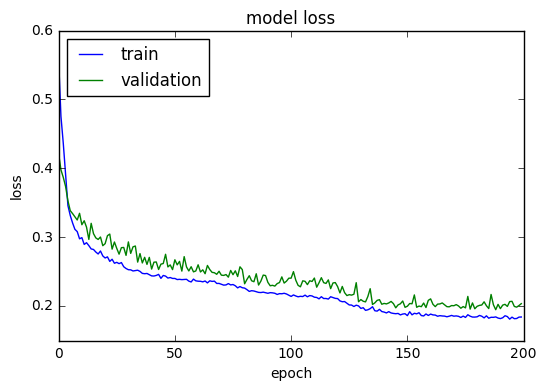

save model in 2D_data/model/sph_2D_v02_d02.h5


In [22]:
import matplotlib.pyplot as plt
from keras.models import load_model

class NthLogger(keras.callbacks.Callback):
    def __init__(self,n=10):
        self.act = 0
        self.n = n

    def on_epoch_end(self,batch,logs={}):
        self.act += 1
        if self.act % self.n == 0 or self.act == 1:
            print('%d/%d - loss: %f val_loss: %f' % (self.act, self.params['epochs'], logs['loss'], logs['val_loss']))
            
history = model.fit(x=train_data.data,y=train_data.ref_data, validation_split=nn_param.val_split, 
                    epochs=nn_param.epochs, batch_size=nn_param.batch_size, 
                    verbose=0, callbacks=[NthLogger()])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model_path = '%smodel/%s_v%02d_d%02d.h5' % (data_loc, data_param.prefix, data_param.nn_version, data_version)
print("save model in %s" % model_path)
model.save(model_path)

**Validate:**

In [23]:
loss_and_metrics = model.evaluate(x=test_data.data, y=test_data.ref_data, batch_size=nn_param.batch_size)
print(loss_and_metrics)

 32/336 [=>............................] - ETA: 0s0.141373610213


### Run Neural Network

#### Show Results

In [24]:
from uniio import *
import keras
from keras.models import load_model
from keras_utils.subpixel import *

timestep = (nn_param.t_start + nn_param.t_end) // 2

model = load_model('%smodel/%s_v%02d_d%02d.h5' % (data_loc, data_param.prefix, data_param.nn_version, data_version), custom_objects={'Subpixel': Subpixel})

test_filename = "%sresult/%s_v%02d" % (data_loc, data_param.prefix, data_version) + "_%03d_sdf" % timestep
ref_filename = "%sresult/ref_%s_v%02d" % (data_loc, data_param.prefix, data_version) + "_%03d_sdf" % timestep
result_filename = "%sresult/result_%s_v%02d" % (data_loc, data_param.prefix, data_version) + "_%03d_sdf" % timestep

#remove_data(test_filename)
#remove_data(ref_filename)
#remove_data(result_filename)

result = model.predict(x=test_data.data, batch_size=nn_param.batch_size)

for patch in test_data.data:
    writeNumpyBuf(test_filename, patch[:,:,0])
    
for patch in test_data.ref_data:
    writeNumpyBuf(ref_filename, patch)
    
for patch in result:
    writeNumpyBuf(result_filename, patch)
    
finalizeNumpyBufs()

In [25]:
param = {}

# show patches
param['src'] = test_filename
param['ref'] = result_filename
param['ref2'] = ref_filename
param['psize'] = data_param.patch_size
param['hpsize'] = high_patch_size
param['t'] = 1

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_patch_%03d_sdf_res.png"

run_manta("scenes/show_patches.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_patches.py psize 5 ref2 2D_data/result/ref_sph_2D_v02_010_sdf ref 2D_data/result/result_sph_2D_v02_010_sdf scr 2D_data/screenshots/20171108/sph_patch_%03d_sdf_res.png src 2D_data/result/sph_2D_v02_010_sdf t 1 hpsize 15

QThread: Destroyed while thread is still running



### Complete Application

In [26]:
import scipy.ndimage.filters as fi

def filter2D(kernlen, s, fac):
    dirac = np.zeros((kernlen, kernlen))
    dirac[kernlen//2, kernlen//2] = 1
    return np.clip(fi.gaussian_filter(dirac, s) * fac, a_min=None, a_max=1.0)

result = np.ndarray(shape=(data_param.res,data_param.res,1), dtype=float)
#weights = np.ndarray(shape=(data_param.res,data_param.res,1), dtype=float)
#weights.fill(0)

ps = data_param.patch_size//2
hps = high_patch_size//2

import math
border = int(math.ceil(hps-(ps*factor_2D)))

result=np.pad(result,((border,border),(border,border),(0,0)),mode="edge")
#weights=np.pad(weights,((border,border),(border,border),(0,0)),mode="edge")
print(result.shape)
dataset = 4#nn_param.train_data_count

input_path = src_prefix + "_d%03d" % dataset + "_%03d"
ref_input_path = ref_prefix + "_d%03d" % dataset + "_%03d_sdf.uni"
print(input_path)
print(ref_input_path)
output_path = "%s%s_v%02d_d%03d" % (data_loc, data_param.prefix, data_version, dataset) + "_%03d_result.uni"
print(output_path)


elem_min = np.vectorize(lambda x,y: min(x,y))
circular_filter = filter2D(high_patch_size, 3, 500)

for t in range(nn_param.t_start, nn_param.t_end):
    result.fill(1)
    hdr, source = readUni(input_path%t+"_sdf.uni")
    for f in nn_param.features:
        if f != "sdf":
            _, tmp = readUni(input_path%t+"_"+f+".uni")
            source = np.append(source, tmp, axis=3)

    for x in range (ps, low_res-ps, 1):
        for y in range(ps, low_res-ps, 1):
            if(abs(source[0,x,y,0]) < data_param.surf):
                x0=x-ps
                x1=x+ps+1
                y0=y-ps
                y1=y+ps+1
                predict = model.predict(x=np.array([source[0,x0:x1,y0:y1]]), batch_size=1)
                #if data_param.use_tanh != 0:
                    #predict = np.arctanh(predict)
                    
                predict = predict * circular_filter/data_param.h_fac



                x0=int(factor_2D*x)-hps+border
                x1=int(factor_2D*x)+hps+border+1
                y0=int(factor_2D*y)-hps+border
                y1=int(factor_2D*y)+hps+border+1

                result[x0:x1,y0:y1,0] = elem_min(result[x0:x1,y0:y1,0], predict[0,:,:,0])

    hdr['dimX'] = data_param.res
    hdr['dimY'] = data_param.res

    #print(result[border:data_param.res+border,border:data_param.res+border,0].shape)
    writeUni(output_path%t, hdr, result[border-1:data_param.res+border-1,border-1:data_param.res+border-1,0])

(152, 152, 1)
2D_data/lowres/sph_2D_v02_d004_%03d
2D_data/highres/ref_sph_2D_v02_d004_%03d_sdf.uni
2D_data/sph_2D_v02_d004_%03d_result.uni


**Show source frame:**

In [27]:
param = {}
dataset = 0

scr_path = "%s_v%02d_d%03d" % (data_param.prefix, data_version, dataset) + "_%03d"

# show input
param['sdf'] = input_path+"_sdf.uni"
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = low_res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + scr_path + "_src.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t_start 5 sres 2 res 50 t_end 15 sdf 2D_data/lowres/sph_2D_v02_d004_%03d_sdf.uni scr 2D_data/screenshots/20171108/sph_2D_v02_d000_%03d_src.png

QThread: Destroyed while thread is still running



**Show result frame:**

In [29]:
param = {}
dataset = 0

# show result
param['sdf'] = output_path
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = data_param.res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + scr_path + "_res.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t_start 5 sres 2 res 150 t_end 15 sdf 2D_data/sph_2D_v02_d004_%03d_result.uni scr 2D_data/screenshots/20171108/sph_2D_v02_d000_%03d_res.png



**Show reference:**

In [36]:
param = {}
dataset = 0

# show result
param['sdf'] = ref_input_path
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = data_param.res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + scr_path + "_ref.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py sdf 2D_data/highres/ref_sph_2D_v02_d004_%03d_sdf.uni t_end 15 t_start 5 scr 2D_data/screenshots/20171108/sph_2D_v02_d000_%03d_ref.png sres 2 res 150

QThread: Destroyed while thread is still running

